Outline
- Step 1: Download and Visualize the Data with its Labels
- Step 2: Preprocess the Dataset
- Step 3: Split the Data into Train and Test Set
- Step 4: Implement the ConvLSTM Approach
  - Step 4.1: Construct the Model
  - Step 4.2: Compile & Train the Model
  - Step 4.3: Plot Model’s Loss & Accuracy Curves
- Step 5: Implement the LRCN Approach
  - Step 5.1: Construct the Model
  - Step 5.2: Compile & Train the Model
  - Step 5.3: Plot Model’s Loss & Accuracy Curves
- Step 6: Test the Best Performing Model on YouTube videos


In [2]:
# Install the required libraries
# Discard the output of this cell.
%%capture
!pip install pafy youtube-dl moviepy

# Import the required libraries
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
# If moviepy is installed correctly, the following import should now work.
try:
    from moviepy.editor import *
except ModuleNotFoundError:
    # If the import still fails, use %pip to install moviepy in the notebook kernel.
    get_ipython().run_line_magic('pip', 'install moviepy')
    from moviepy.editor import *

%matplotlib inline

# Model selection and utility imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

  if event.key is 'enter':



In [3]:
# Set Numpy, Python, and TensorFlow seeds to get consistent results on every execution.
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)


In the first step, we will download and visualize the data along with labels to get an idea about what we will be dealing with.
We will be using the UCF50 - Action Recognition Dataset, consisting of realistic videos taken from YouTube, which differentiates
this dataset from most of the other available action recognition datasets as they are not realistic and are staged by actors.

The Dataset contains:
- 50 Action Categories
- 25 Groups of Videos per Action Category
- 133 Average Videos per Action Category
- 199 Average Number of Frames per Video
- 320 Average Frames Width per Video
- 240 Average Frames Height per Video
- 26 Average Frames Per Second per Video

Let's download and extract the dataset.


In [4]:
# Discard the output of this cell.
%%capture

# Download the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# Extract the Dataset
!unrar x UCF50.rar


For visualization, we will pick 20 random categories from the dataset and a random video from each selected category. We will visualize the first frame of the selected videos with their associated labels written. This way, we'll be able to visualize a subset (20 random videos) of the dataset.

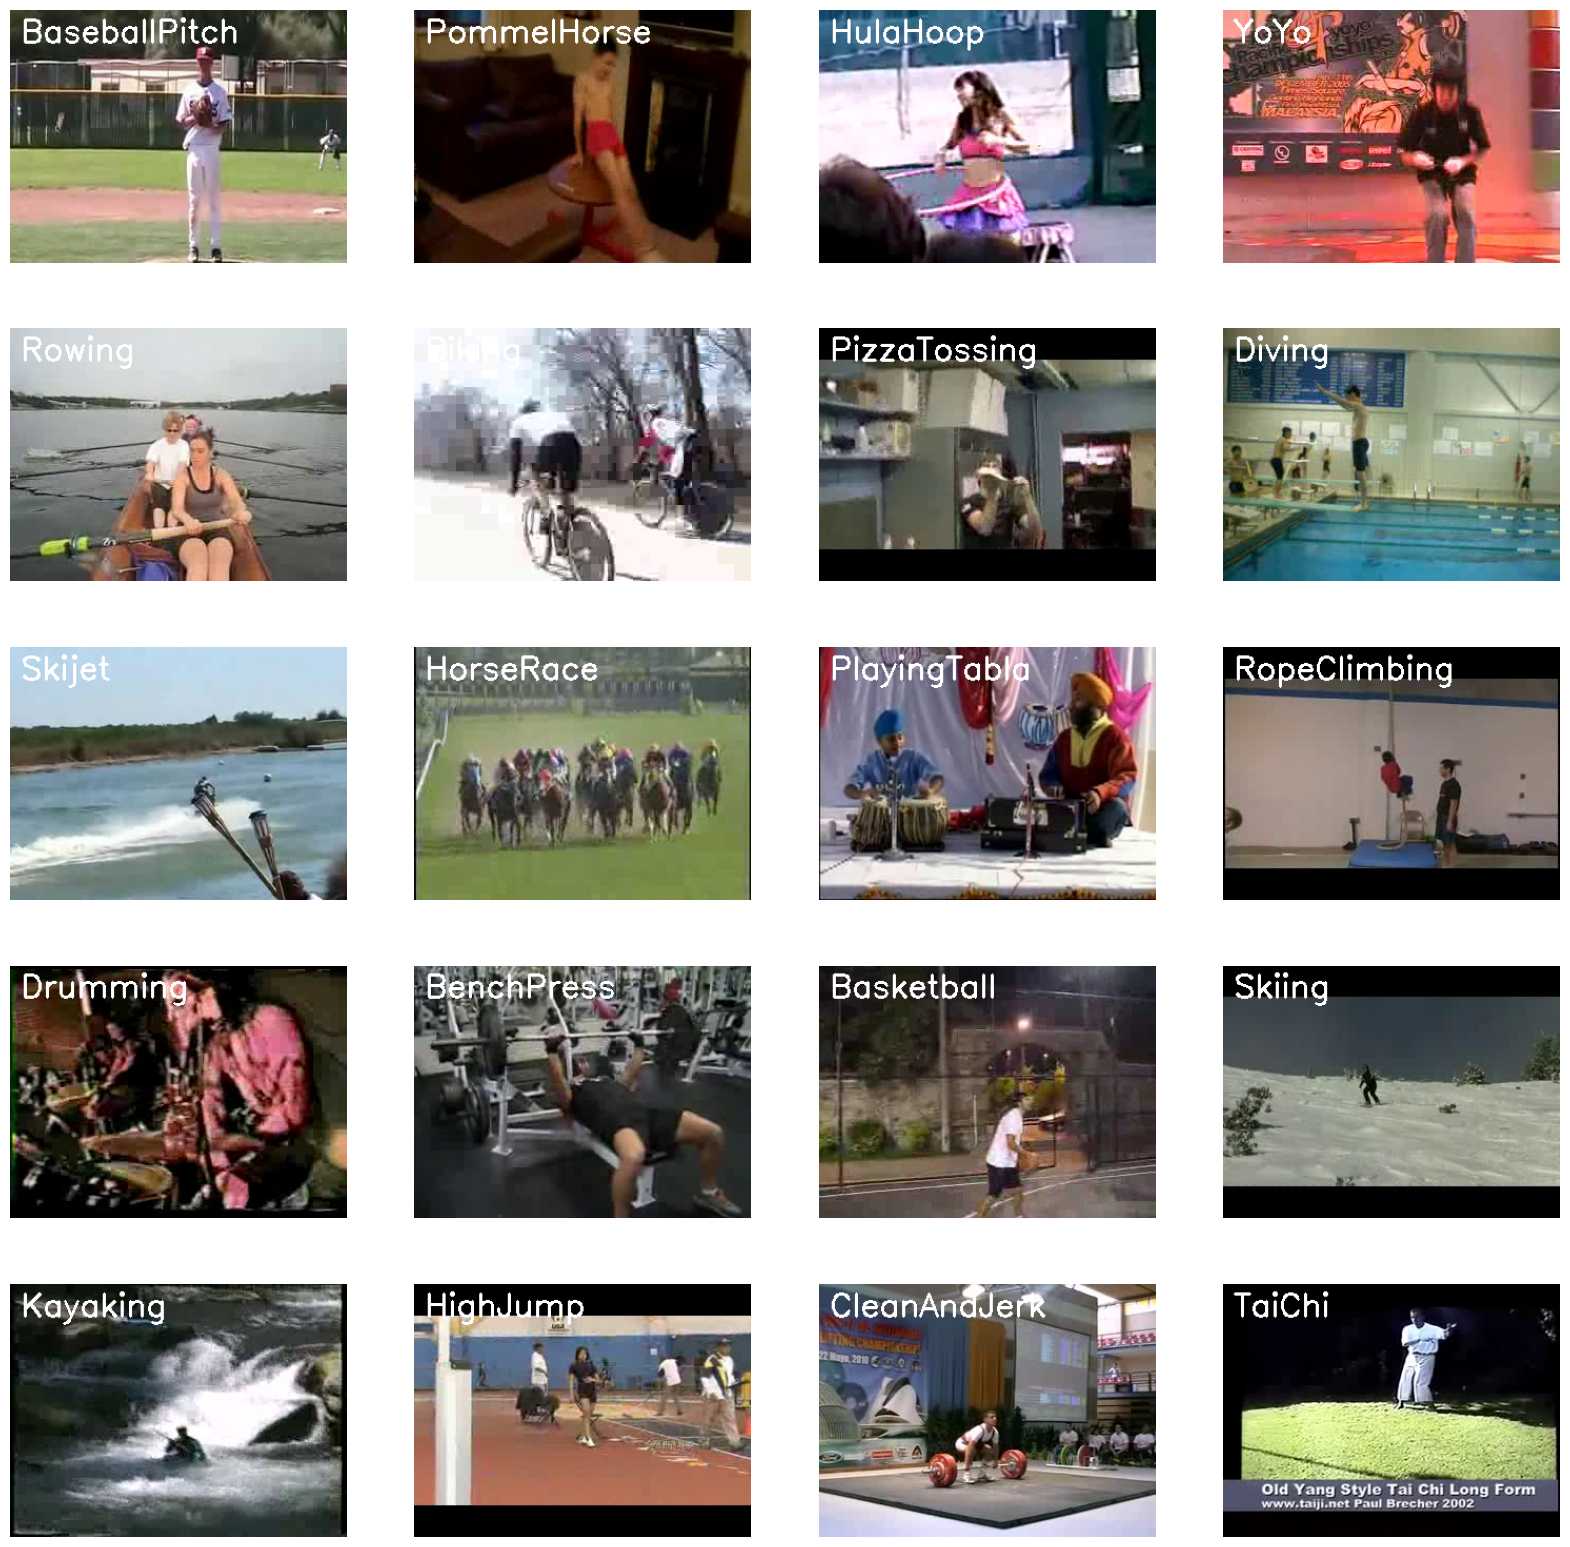

In [5]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize=(20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random values where S is the total number of items in a container.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
    # Retrieve a Class Name using the Random Index.
    selected_class_name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR to RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the frame.
    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')


## Step 2: Preprocess the Dataset
Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalize the data to the range [0-1] by dividing the pixel values with 255, which makes convergence faster while training the network.

But first, let’s initialize some constants.

In [6]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]


Create a Function to Extract, Resize & Normalize Frames
We will create a function frames_extraction() that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequence length of frames.

In [7]:
def frames_extraction(video_path):
    """
    This function will extract the required frames from a video after resizing and normalizing them.

    Args:
    video_path: The path of the video in the disk, whose frames are to be extracted.

    Returns:
    frames_list: A list containing the resized and normalized frames of the video.
    """
    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop.
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list.
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list


Create a Function for Dataset Creation
Now we will create a function create_dataset() that will iterate through all the classes specified in the CLASSES_LIST constant and will call the function frames_extraction() on every video file of the selected classes and return the frames (features), class index (labels), and video file path (video_files_paths).

In [8]:
def create_dataset():
    """
    This function will extract the data of the selected classes and create the required dataset.

    Returns:
    features: A list containing the extracted frames of the videos.
    labels: A list containing the indexes of the classes associated with the videos.
    video_files_paths: A list containing the paths of the videos in the disk.
    """
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list.
    for class_index, class_name in enumerate(CLASSES_LIST):
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
                # Append the data to their respective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the lists to numpy arrays.
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths


Now we will utilize the function create_dataset() created above to extract the data of the selected classes and create the required dataset.

In [9]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()


Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


Now we will convert labels (class indexes) into one-hot encoded vectors.

In [10]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors.
one_hot_encoded_labels = to_categorical(labels)


##Step 3: Split the Data into Train and Test Set
As of now, we have the required features (a NumPy array containing all the extracted frames of the videos) and one_hot_encoded_labels (also a NumPy array containing all class labels in one-hot encoded format). So now, we will split our data to create training and testing sets. We will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [11]:
# Split the Data into Train (75%) and Test Set (25%).
features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_encoded_labels,
    test_size=0.25, shuffle=True,
    random_state=seed_constant
)


Step 4: Implement the ConvLSTM Approach
In this step, we will implement the first approach by using a combination of ConvLSTM cells. A ConvLSTM cell is a variant of an LSTM network that contains convolution operations in the network. It is an LSTM with convolution embedded in the architecture, which makes it capable of identifying spatial features of the data while keeping into account the temporal relation.
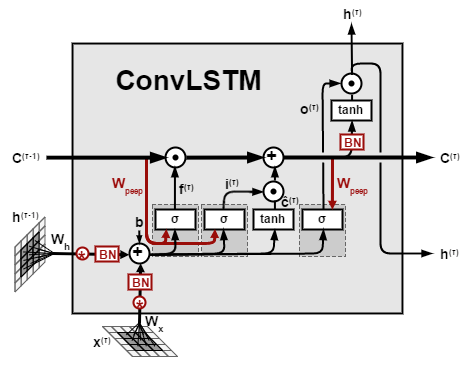

For video classification, this approach effectively captures the spatial relation in the individual frames and the temporal relation across the different frames. As a result of this convolution structure, the ConvLSTM is capable of taking in 3-dimensional input (width, height, num_of_channels) whereas a simple LSTM only takes in 1-dimensional input. Hence, an LSTM is incompatible for modeling spatio-temporal data on its own.

You can read the paper **"Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting" by Xingjian Shi (NIPS 2015)** to learn more about this architecture.

##Step 4.1: Construct the Model
To construct the model, we will use Keras's ConvLSTM2D recurrent layers. The ConvLSTM2D layer also takes in the number of filters and kernel size required for applying the convolutional operations. The output of the layers is flattened in the end and is fed to the Dense layer with softmax activation, which outputs the probability of each action category.

We will also use MaxPooling3D layers to reduce the dimensions of the frames and avoid unnecessary computations, and Dropout layers to prevent overfitting the model on the data. The architecture is a simple one and has a small number of trainable parameters. This is because we are only dealing with a small subset of the dataset, which does not require a large-scale model.

In [12]:
def create_convlstm_model():
    """
    This function will construct the required ConvLSTM model.

    Returns:
    model: It is the required constructed ConvLSTM model.
    """
    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ################################################################
    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh',
                         data_format="channels_last", recurrent_dropout=0.2,
                         return_sequences=True,
                         input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh',
                         data_format="channels_last", recurrent_dropout=0.2,
                         return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh',
                         data_format="channels_last", recurrent_dropout=0.2,
                         return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh',
                         data_format="channels_last", recurrent_dropout=0.2,
                         return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation="softmax"))

    ################################################################

    # Display the model summary.
    model.summary()

    # Return the constructed ConvLSTM model.
    return model


###Utilizing the Function to Construct the ConvLSTM Model
Now we will utilize the function create_convlstm_model() created above to construct the required ConvLSTM model.

In [13]:
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense # Importing ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, and Dense


In [14]:
# Construct the required ConvLSTM model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")


  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │          11,524 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,524 (173.92 KB)

 Trainable params: 44,524 (173.92 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


###Check Model's Structure
Now we will use the plot_model() function to check the structure of the constructed model. This is helpful while constructing a complex network and ensuring that the network is created correctly.

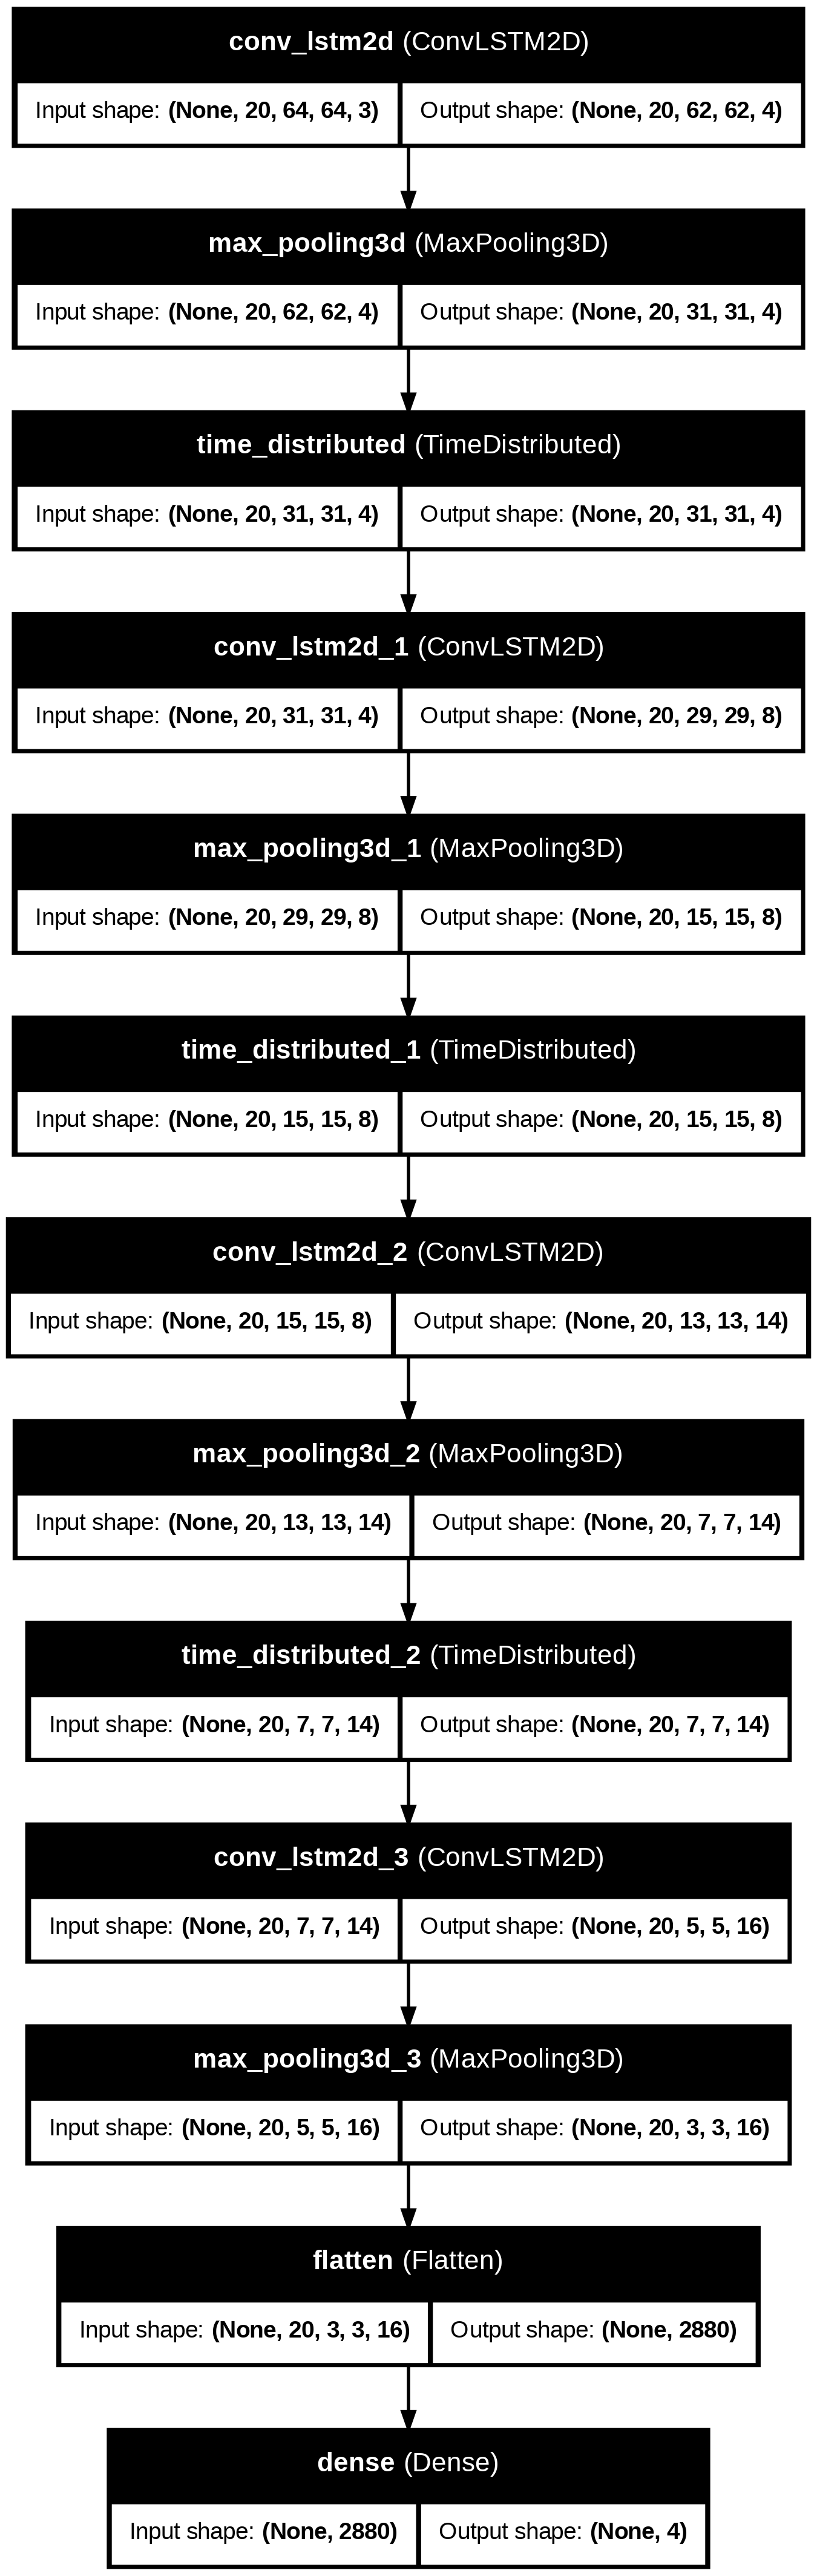

In [15]:
# Plot the structure of the constructed model.
plot_model(convlstm_model, to_file='convlstm_model_structure_plot.png',
           show_shapes=True, show_layer_names=True)


##Step 4.2: Compile & Train the Model
Next, we will add an early stopping callback to prevent overfitting and start the training after compiling the model.

In [16]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Compile the model and specify loss function, optimizer, and metrics values to the model
convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Start training the model
convlstm_model_training_history = convlstm_model.fit(
    x=features_train, y=labels_train, epochs=50, batch_size=4,
    shuffle=True, validation_split=0.2,
    callbacks=[early_stopping_callback]
)


Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 75s 129ms/step - accuracy: 0.2965 - loss: 1.3740 - val_accuracy: 0.3973 - val_loss: 1.3602
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.3736 - loss: 1.3310 - val_accuracy: 0.4110 - val_loss: 1.2642
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5464 - loss: 1.1862 - val_accuracy: 0.4521 - val_loss: 1.1793
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.5502 - loss: 1.0691 - val_accuracy: 0.5479 - val_loss: 1.0990
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5566 - loss: 1.0335 - val_accuracy: 0.5753 - val_loss: 1.0286
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5656 - loss: 0.9196 - val_accuracy: 0.6027 - val_loss: 0.8305
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6797 - loss: 0.7151 - val_accuracy: 0.6849 - val_loss: 0.7406
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.7135 - loss: 0.6652 - val_accuracy: 0.6849 -

###Evaluate the Trained Model
After training, we will evaluate the model on the test set.

In [17]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)



4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 741ms/step - accuracy: 0.7432 - loss: 0.6690


###Save the Model
Now we will save the model to avoid training it from scratch every time we need the model.

In [18]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = "%Y_%m_%d__%H_%M_%S"
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model__DateTime_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

# Save your model.
convlstm_model.save(model_file_name)


##Step 4.3: Plot Model’s Loss & Accuracy Curves
Now we will create a function plot_metric() to visualize the training and validation metrics. We already have separate metrics from our training and validation steps, so now we just have to visualize them.

In [19]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    """
    This function will plot the metrics passed to it in a graph.

    Args:
    model_training_history: A History object containing a record of training and validation
                            loss values and metrics values at successive epochs.
    metric_name_1: The name of the first metric that needs to be plotted in the graph.
    metric_name_2: The name of the second metric that needs to be plotted in the graph.
    plot_name: The title of the graph.
    """
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()


###Utilizing the plot_metric() Function
Now we will utilize the function plot_metric() created above, to visualize and understand the metrics.

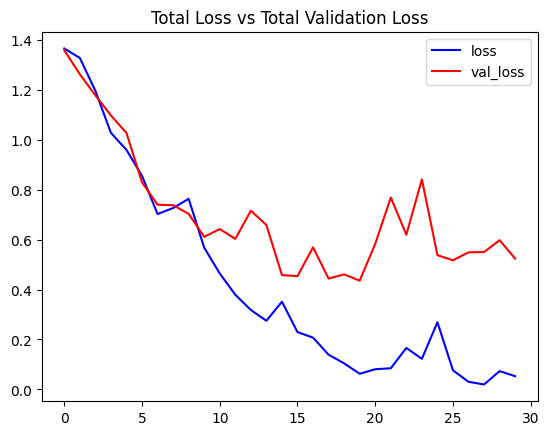

In [20]:
# Visualize the training and validation loss metrics.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')


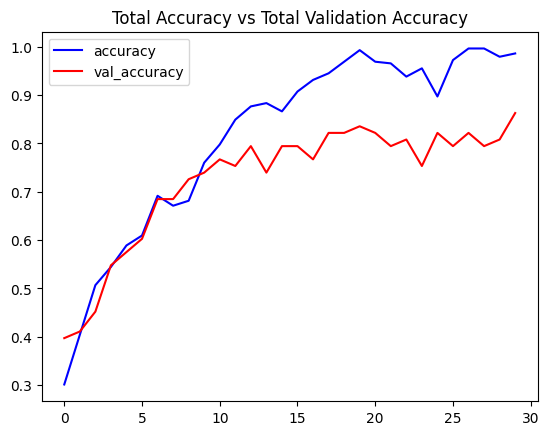

In [21]:

# Visualize the training and validation accuracy metrics.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')


###Implementing the Long-term Recurrent Convolutional Network (LRCN) Approach
In this step, we will implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model.

The Convolutional layers are used for spatial feature extraction from the frames.

The extracted spatial features are fed to LSTM layers at each time step for temporal sequence modeling.

This way, the network learns spatiotemporal features directly in an end-to-end training manner, resulting in a robust model.


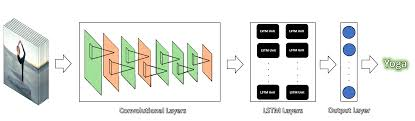

#### TimeDistributed Wrapper
We will also use the TimeDistributed wrapper layer, which applies the same layer to every frame of the video independently.

It enables input of shape (no_of_frames, width, height, num_of_channels) to layers like CNN.

Normally, the input shape is (width, height, num_of_channels) for individual images.

This approach is beneficial as it allows us to input the whole video into the model in a single shot.

This wrapper effectively makes it possible to process sequences of frames (videos) while treating each frame independently for spatial feature extraction.

##Step 5.1: Construct the Model
To implement our LRCN architecture, we will use time-distributed Conv2D layers, which will be followed by MaxPooling2D and Dropout layers.

The feature extracted from the Conv2D layers will then be flattened using the Flatten layer and fed to an LSTM layer.
The Dense layer with softmax activation will use the output from the LSTM layer to predict the action being performed.

In [22]:
def create_LRCN_model():
    """
    This function will construct the required LRCN model.

    Returns:
    model: It is the required constructed LRCN model.
    """
    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ################################################################
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                               input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    ################################################################

    # Display the model's summary.
    model.summary()

    # Return the constructed LRCN model.
    return model



Now we will utilize the function create_LRCN_model() created above to construct the required LRCN model.

In [23]:
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense


In [24]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")


  super().__init__(**kwargs)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_3 (TimeDistributed) │ (None, 20, 64, 64, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 20, 32, 32, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 20, 32, 32, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 20, 32, 32, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 20, 16, 16, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 20, 16, 16, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 20, 16, 16, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 20, 8, 8, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 20, 8, 8, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 20, 4096)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │         528,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 552,228 (2.11 MB)

 Trainable params: 552,228 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


####Check Model's Structure
Now we will use the plot_model() function to check the structure of the constructed LRCN model, as we had checked for the previous model.

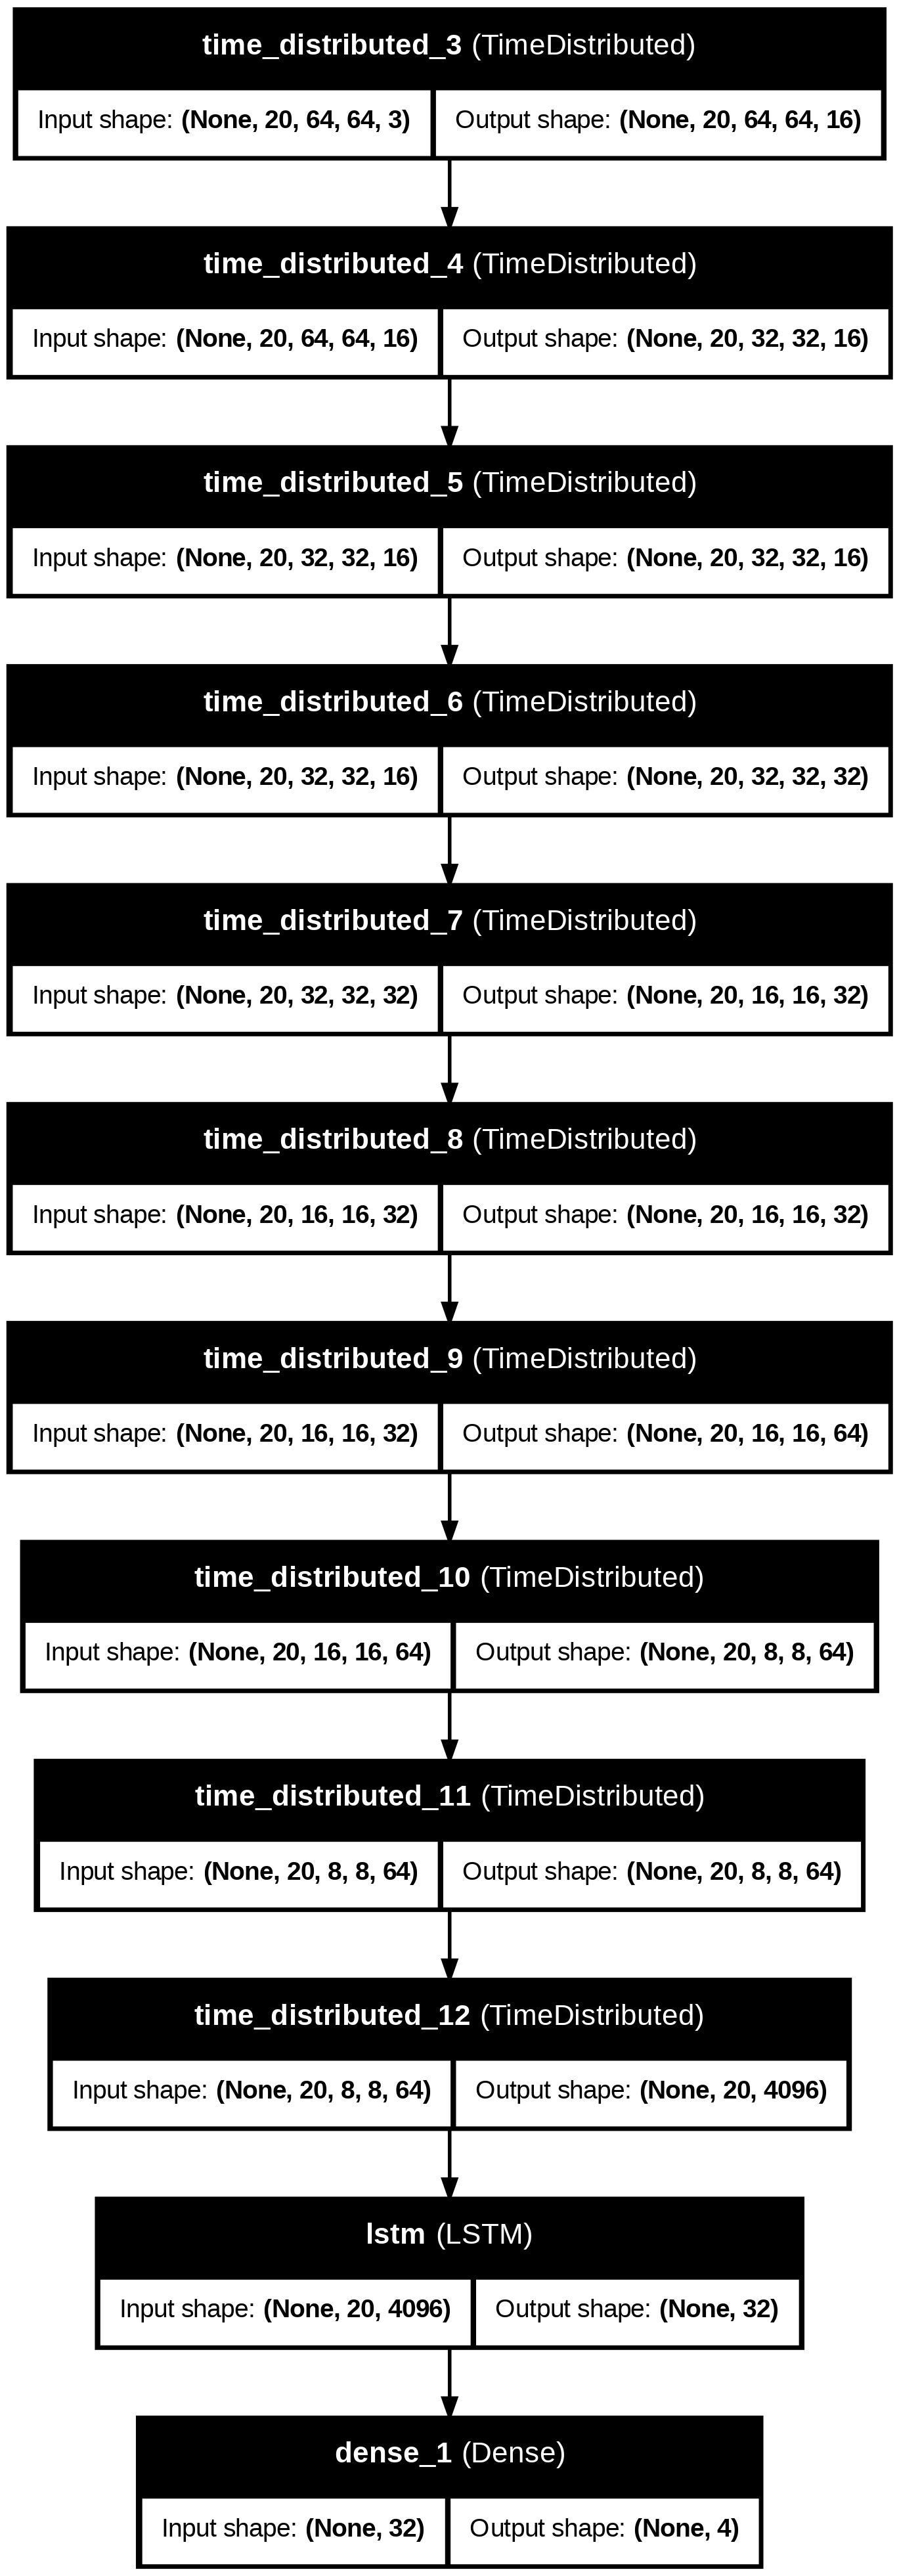

In [25]:
# Plot the structure of the constructed LRCN model.
plot_model(LRCN_model, to_file='LRCN_model_structure_plot.png',
           show_shapes=True, show_layer_names=True)


##Step 5.2: Compile & Train the Model
After checking the structure, we will compile and start training the model.

In [26]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

# Compile the model and specify loss function, optimizer, and metrics to the model.
LRCN_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(
    x=features_train, y=labels_train, epochs=70, batch_size=4,
    shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback]
)


Epoch 1/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.1858 - loss: 1.5204 - val_accuracy: 0.4247 - val_loss: 1.3300
Epoch 2/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.3698 - loss: 1.3344 - val_accuracy: 0.4658 - val_loss: 1.3061
Epoch 3/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4105 - loss: 1.2738 - val_accuracy: 0.4795 - val_loss: 1.2883
Epoch 4/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5210 - loss: 1.1311 - val_accuracy: 0.4658 - val_loss: 1.1696
Epoch 5/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.5261 - loss: 1.0549 - val_accuracy: 0.5068 - val_loss: 1.1575
Epoch 6/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6036 - loss: 0.9833 - val_accuracy: 0.5342 - val_loss: 1.1137
Epoch 7/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6490 - loss: 0.9273 - val_accuracy: 0.6712 - val_loss: 0.9668
Epoch 8/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.6913 - loss: 0.7933 - val_accuracy: 0.5890 - 

####Evaluating the Trained Model
As done for the previous one, we will evaluate the LRCN model on the test set.

In [27]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8691 - loss: 0.3706


##Step 5.3: Plot Model's Loss & Accuracy Curves
Now we will utilize the function plot_metric() we had created above to visualize the training and validation metrics of this model.

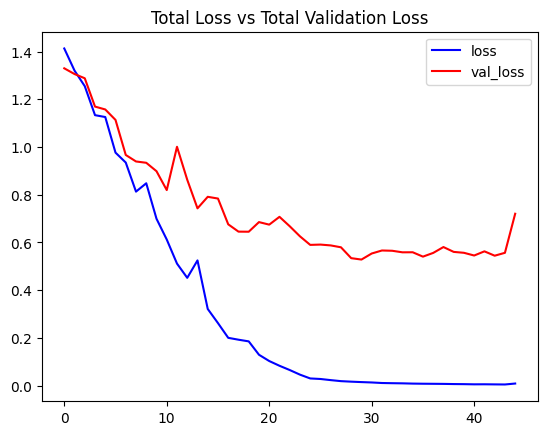

In [28]:
# Visualize the training and validation loss metrics.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')


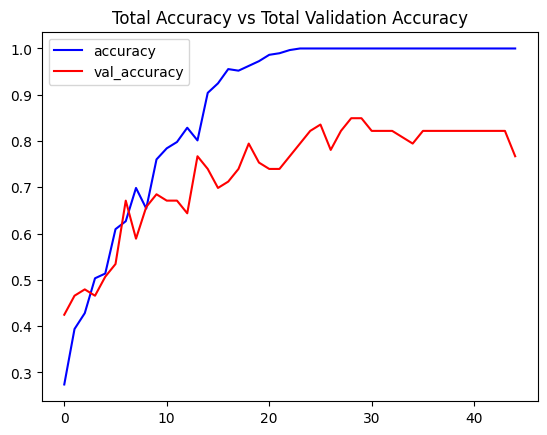

In [29]:
# Visualize the training and validation accuracy metrics.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')


##Step 6: Test the Best Performing Model on YouTube Videos
From the results, it seems that the LRCN model performed significantly well for a small number of classes. So in this step, we will put the LRCN model to the test on some YouTube videos.

####Create a Function to Download YouTube Videos
We will create a function download_youtube_videos() to download YouTube videos using the pafy library. The library only requires a URL to a video to download it along with its associated metadata, like the title of the video.

In [30]:
def download_youtube_videos(youtube_video_url, output_directory):
    """
    This function downloads the YouTube video whose URL is passed to it as an argument.

    Args:
    youtube_video_url: URL of the video that is required to be downloaded.
    output_directory: The directory path to which the video needs to be stored after downloading.

    Returns:
    title: The title of the downloaded YouTube video.
    """
    # Create a video object which contains useful information about the video.
    # Passing ydl_opts with verbose=False to suppress detailed output and avoid regex issues
    video = pafy.new(youtube_video_url, ydl_opts={'verbose': False})

    # Retrieve the title of the video.
    title = video.title

    # Get the best available quality object for the video.
    video_best = video.getbest()

    # Construct the output file path.
    output_file_path = f'{output_directory}/{title}.mp4'

    # Download the YouTube video at the best available quality and store it to the constructed path.
    video_best.download(filepath=output_file_path, quiet=True)

    # Return the video title.
    return title

####Download a Test Video
Now we will utilize the function download_youtube_videos() created above to download a YouTube video on which the LRCN model will be tested.

In [31]:
pip install yt-dlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 86.2 MB/s eta 0:00:00


In [32]:
import os
import yt_dlp

# Function to download YouTube video
def download_youtube_video(url, output_dir):
    ydl_opts = {
        'outtmpl': f'{output_dir}/%(title)s.%(ext)s',  # Save with video title and extension
        'format': 'bestvideo+bestaudio/best',  # Best quality
        'quiet': False,  # Set True if you want no output
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)  # Download video
        return info['title'], info['ext']  # Return title and file extension

# Create the output directory if it doesn't exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok=True)

# Download the YouTube video
video_url = 'https://youtu.be/NsZaY-EMpiA'
video_title, video_ext = download_youtube_video(video_url, test_videos_directory)

# Construct the path for the downloaded video
input_video_file_path = f"{test_videos_directory}/{video_title}.{video_ext}"
print(f"Video downloaded to: {input_video_file_path}")


[youtube] Extracting URL: https://youtu.be/NsZaY-EMpiA
[youtube] NsZaY-EMpiA: Downloading webpage
[youtube] NsZaY-EMpiA: Downloading ios player API JSON
[youtube] NsZaY-EMpiA: Downloading mweb player API JSON
[youtube] NsZaY-EMpiA: Downloading player b46bb280
[youtube] NsZaY-EMpiA: Downloading m3u8 information
[info] NsZaY-EMpiA: Downloading 1 format(s): 399+251
[download] Destination: test_videos/Tai Chi Step by Step For Beginners Training Session 1.f399.mp4
[download] 100% of  309.64MiB in 00:00:08 at 35.81MiB/s  
[download] Destination: test_videos/Tai Chi Step by Step For Beginners Training Session 1.f251.webm
[download] 100% of   20.35MiB in 00:00:00 at 25.40MiB/s  
[Merger] Merging formats into "test_videos/Tai Chi Step by Step For Beginners Training Session 1.webm"
Deleting original file test_videos/Tai Chi Step by Step For Beginners Training Session 1.f399.mp4 (pass -k to keep)
Deleting original file test_videos/Tai Chi Step by Step For Beginners Training Session 1.f251.webm (p

In [36]:
pip uninstall youtube-dl


Found existing installation: youtube-dl 2021.12.17
Uninstalling youtube-dl-2021.12.17:
  Would remove:
    /usr/local/bin/youtube-dl
    /usr/local/etc/bash_completion.d/youtube-dl.bash-completion
    /usr/local/etc/fish/completions/youtube-dl.fish
    /usr/local/lib/python3.10/dist-packages/youtube_dl-2021.12.17.dist-info/*
    /usr/local/lib/python3.10/dist-packages/youtube_dl/*
    /usr/local/share/doc/youtube_dl/README.txt
    /usr/local/share/man/man1/youtube-dl.1
Proceed (Y/n)? y
  Successfully uninstalled youtube-dl-2021.12.17


In [37]:
pip install yt-dlp


In [41]:
import os
import yt_dlp

# Function to download a YouTube video
def download_youtube_video(url, output_dir):
    ydl_opts = {
        'outtmpl': f'{output_dir}/%(title)s.%(ext)s',  # Save video using its title and extension
        'format': 'bestvideo+bestaudio/best',  # Best quality available
        'quiet': False,  # Set to True to suppress output
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)  # Download the video
        return info['title'], info['ext']  # Return video title and extension

# Create output directory if it doesn't exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok=True)

# URL of the YouTube video
video_url = 'https://www.youtube.com/shorts/NoW-wKanTSw?feature=share'

# Download the video
video_title, video_ext = download_youtube_video(video_url, test_videos_directory)

# Get the video file path
input_video_file_path = f"{test_videos_directory}/{video_title}.{video_ext}"
print(f"Video downloaded to: {input_video_file_path}")


[youtube] Extracting URL: https://www.youtube.com/shorts/NoW-wKanTSw?feature=share
[youtube] NoW-wKanTSw: Downloading webpage
[youtube] NoW-wKanTSw: Downloading ios player API JSON
[youtube] NoW-wKanTSw: Downloading mweb player API JSON
[youtube] NoW-wKanTSw: Downloading m3u8 information
[info] NoW-wKanTSw: Downloading 1 format(s): 247+251
[download] Destination: test_videos/shaolin tai chi short video.f247.webm
[download] 100% of  826.45KiB in 00:00:00 at 10.96MiB/s  
[download] Destination: test_videos/shaolin tai chi short video.f251.webm
[download] 100% of  126.52KiB in 00:00:00 at 201.55KiB/s 
[Merger] Merging formats into "test_videos/shaolin tai chi short video.webm"
Deleting original file test_videos/shaolin tai chi short video.f247.webm (pass -k to keep)
Deleting original file test_videos/shaolin tai chi short video.f251.webm (pass -k to keep)
Video downloaded to: test_videos/shaolin tai chi short video.webm


Create a Function to Perform Action Recognition on Videos
Next, we will create a function predict_on_video() that will simply read a video frame by frame from the path passed in as an argument and will perform action recognition on it while saving the results.

In [42]:
import os
import cv2
import numpy as np
from collections import deque

def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    """
    Perform action recognition on a video using the LRCN model.

    Args:
    - video_file_path: Path to the input video.
    - output_file_path: Path to save the output video with predictions.
    - SEQUENCE_LENGTH: Number of frames in a sequence for model input.
    """
    if not os.path.exists(video_file_path):
        raise FileNotFoundError(f"Video file not found: {video_file_path}")

    if os.path.exists(output_file_path):
        raise FileExistsError(f"Output file already exists: {output_file_path}")

    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    if original_video_width == 0 or original_video_height == 0:
        raise ValueError("Invalid video file. Could not read dimensions.")

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS),
                                   (original_video_width, original_video_height))

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name = ''
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_count = 0

    try:
        while video_reader.isOpened():
            ok, frame = video_reader.read()
            if not ok:
                break

            frame_count += 1
            print(f"Processing frame {frame_count}/{total_frames}", end="\r")

            resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
            normalized_frame = resized_frame / 255.0
            frames_queue.append(normalized_frame)

            if len(frames_queue) == SEQUENCE_LENGTH:
                predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis=0))[0]
                predicted_label = np.argmax(predicted_labels_probabilities)
                predicted_class_name = CLASSES_LIST[predicted_label]

            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            video_writer.write(frame)
    finally:
        video_reader.release()
        video_writer.release()

    print("\nProcessing complete. Output saved to:", output_file_path)


####Perform Action Recognition on the Test Video
Now we will utilize the function predict_on_video() created above to perform action recognition on the test video we had downloaded using the function download_youtube_videos() and display the output video with the predicted action overlaid on it.

In [43]:
import os
import re
from moviepy.video.io.VideoFileClip import VideoFileClip

# Sanitize video title to avoid invalid file names
safe_video_title = re.sub(r'[\\/*?:"<>|]', "", video_title)

# Construct the output video path
output_video_file_path = f'{test_videos_directory}/{safe_video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Check if SEQUENCE_LENGTH is valid
if not isinstance(SEQUENCE_LENGTH, int) or SEQUENCE_LENGTH <= 0:
    raise ValueError("SEQUENCE_LENGTH must be a positive integer.")

# Check for existing output file
if os.path.exists(output_video_file_path):
    print(f"Warning: Output file {output_video_file_path} already exists and will be overwritten.")

# Perform Action Recognition on the Test Video
print("Starting action recognition on the video...")
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
print(f"Action recognition complete. Output saved to {output_video_file_path}")

# Display the output video
try:
    print("Displaying the output video...")
    VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None)).ipython_display()
except Exception as e:
    print(f"Error displaying video: {e}")


Starting action recognition on the video...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━

Moviepy - Done !
Moviepy - video ready __temp__.mp4


####Create a Function to Perform a Single Prediction on Videos
This function performs a single prediction for a video by extracting evenly distributed N frames (SEQUENCE_LENGTH) and passing them to the LRCN model. It is particularly useful for videos containing only one activity, as it saves computation time.

In [44]:
import os
import cv2
import numpy as np

def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    """
    Perform single action recognition prediction on a video using the LRCN model.

    Args:
    - video_file_path: Path to the input video file.
    - SEQUENCE_LENGTH: Number of frames required for model input.

    Returns:
    - predicted_class_name: The name of the predicted action.
    - confidence: The confidence score of the prediction.
    """
    if not os.path.exists(video_file_path):
        raise FileNotFoundError(f"Video file not found: {video_file_path}")

    if not isinstance(SEQUENCE_LENGTH, int) or SEQUENCE_LENGTH <= 0:
        raise ValueError("SEQUENCE_LENGTH must be a positive integer.")

    video_reader = cv2.VideoCapture(video_file_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    if video_frames_count == 0:
        raise ValueError("The video contains no frames or is unreadable.")

    if video_frames_count < SEQUENCE_LENGTH:
        raise ValueError(f"The video contains fewer frames ({video_frames_count}) than the required sequence length ({SEQUENCE_LENGTH}).")

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    if original_video_width == 0 or original_video_height == 0:
        raise ValueError("Unable to read video dimensions.")

    frames_list = []
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    try:
        for frame_counter in range(SEQUENCE_LENGTH):
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
            success, frame = video_reader.read()
            if not success:
                print(f"Frame {frame_counter} could not be read. Skipping...")
                continue

            resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
            normalized_frame = resized_frame / 255.0
            frames_list.append(normalized_frame)

        if len(frames_list) < SEQUENCE_LENGTH:
            raise ValueError(f"Could not gather sufficient frames ({len(frames_list)}/{SEQUENCE_LENGTH}).")

        predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis=0))[0]
        predicted_label = np.argmax(predicted_labels_probabilities)
        predicted_class_name = CLASSES_LIST[predicted_label]
        confidence = predicted_labels_probabilities[predicted_label]

        print(f"Action Predicted: {predicted_class_name}\nConfidence: {confidence:.2f}")
        return predicted_class_name, confidence

    finally:
        video_reader.release()


####Perform Single Prediction on a Test Video
Now we will utilize the function predict_single_action() created above to perform a single prediction on a complete YouTube test video that we will download using the function download_youtube_videos() created earlier

In [52]:
import os
from moviepy.video.io.VideoFileClip import VideoFileClip
import yt_dlp
import re

def sanitize_filename(filename):
    """
    Sanitize file name by removing problematic characters.
    Args:
    - filename: Original file name.
    Returns:
    - Sanitized file name.
    """
    return re.sub(r'[\/:*?"<>|]', '_', filename)

def download_youtube_videos(url, output_directory):
    """
    Download a YouTube video and return the sanitized path of the downloaded video file.
    Args:
    - url: The YouTube video URL.
    - output_directory: The directory where the video will be saved.
    Returns:
    - output_file_path: The full sanitized path to the downloaded video file.
    """
    ydl_opts = {
        'outtmpl': f'{output_directory}/%(title)s.%(ext)s',  # Save with title as filename
        'format': 'bestvideo+bestaudio/best',               # Download best quality video and audio
        'merge_output_format': 'mp4'                        # Ensure the output is in MP4 format
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        result = ydl.extract_info(url, download=True)       # Download video
        output_file_path = ydl.prepare_filename(result)     # Get the exact file path
        sanitized_path = sanitize_filename(output_file_path)
        if output_file_path != sanitized_path:
            os.rename(output_file_path, sanitized_path)     # Rename to sanitized path
        return sanitized_path

# Ensure the test videos directory exists
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok=True)

# Download the YouTube video
try:
    video_url = 'https://www.youtube.com/watch?v=MKOd5AZnEX0'  # Replace with your YouTube video URL
    downloaded_video_path = download_youtube_videos(video_url, test_videos_directory)
except Exception as e:
    raise RuntimeError(f"Failed to download YouTube video: {e}")

# Ensure the video file exists
if not os.path.exists(downloaded_video_path):
    raise FileNotFoundError(f"Downloaded video file not found: {downloaded_video_path}")

# Ensure SEQUENCE_LENGTH is valid
SEQUENCE_LENGTH = 30  # Example value, update as needed
if not isinstance(SEQUENCE_LENGTH, int) or SEQUENCE_LENGTH <= 0:
    raise ValueError("SEQUENCE_LENGTH must be a positive integer.")

# Perform Single Prediction on the Test Video
try:
    print("Performing action recognition prediction on the video...")
    predict_single_action(downloaded_video_path, SEQUENCE_LENGTH)
except Exception as e:
    print(f"Error during prediction: {e}")

# Display the input video
try:
    print("Displaying the input video...")
    VideoFileClip(downloaded_video_path, audio=False, target_resolution=(300, None)).ipython_display()
except Exception as e:
    print(f"Error displaying video: {e}")


[youtube] Extracting URL: https://www.youtube.com/watch?v=MKOd5AZnEX0
[youtube] MKOd5AZnEX0: Downloading webpage
[youtube] MKOd5AZnEX0: Downloading ios player API JSON
[youtube] MKOd5AZnEX0: Downloading mweb player API JSON
[youtube] MKOd5AZnEX0: Downloading m3u8 information
[info] MKOd5AZnEX0: Downloading 1 format(s): 313+251
[download] Destination: test_videos/Horse Riding ｜ Cinematic Short Film ｜ SONY A7SIII.f313.webm
[download] 100% of   73.66MiB in 00:00:02 at 24.87MiB/s  
[download] Destination: test_videos/Horse Riding ｜ Cinematic Short Film ｜ SONY A7SIII.f251.webm
[download] 100% of    1.99MiB in 00:00:00 at 7.87MiB/s   
[Merger] Merging formats into "test_videos/Horse Riding ｜ Cinematic Short Film ｜ SONY A7SIII.mp4"
Deleting original file test_videos/Horse Riding ｜ Cinematic Short Film ｜ SONY A7SIII.f313.webm (pass -k to keep)
Deleting original file test_videos/Horse Riding ｜ Cinematic Short Film ｜ SONY A7SIII.f251.webm (pass -k to keep)
Performing action recognition predictio

t: 100%|█████████▉| 3018/3021 [02:21<00:00, 40.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file test_videos_Horse Riding ｜ Cinematic Short Film ｜ SONY A7SIII.mp4, 479700 bytes wanted but 0 bytes read,at frame 3020/3021, at time 120.80/120.82 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                                

Moviepy - Done !
Moviepy - video ready __temp__.mp4
Error displaying video: The duration of video __temp__.mp4 (120.8) exceeds the 'maxduration' attribute. You can increase 'maxduration', by passing 'maxduration' parameterto ipython_display function.But note that embedding large videos may take all the memory away !
